## CNN for 2D xy images

In [7]:
%matplotlib inline 
#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [8]:
import random            as random
import numpy             as np
import pandas            as pd
#import tables            as tb
import matplotlib.pyplot as plt
import os 

In [3]:
import xyimg.dataprep as dp
import xyimg.cnn      as cnn

## Test

In [127]:
path = os.environ['LPRDATADIR']+'xymm/'

pressure = '13bar'
coors  = ('x', 'y')
widths = (10, 10)
frame  = dp.frames[pressure]
ifile = path + dp.xymm_filename(coors, widths, frame, prefix = 'xymm_'+pressure)

cnn.test(ifile)

input filename  /scratch/next/data/NEXT100/pressure_topology/xymm/xymm_13bar_xy_10x10_100.npz
output filename  /scratch/next/data/NEXT100/pressure_topology/xymm/test_cnn_xymm_13bar_xy_10x10_100.npz
--- data set test ---
Dataset : 
   labels   : ['test']
   x shape  : (200038, 1, 10, 10)
   y shape  : (200038, 1)
   z labels : dict_keys(['seg', 'ext'])
   z shape  : (200038, 2, 10, 10)

Event Image tensor  (1, 10, 10)
CNN : 
   [200, 1, 10, 10] > [200, 2, 5, 5] > [200, 4, 3, 3] > [200, 8, 2, 2] > [200, 32] > [200, 2]
 > [200, 1]

Epoch:  train 0.116 +- 0.177  validation 0.034 +- 0.006
Epoch:  train 0.027 +- 0.006  validation 0.022 +- 0.004
Epoch:  train 0.019 +- 0.005  validation 0.015 +- 0.003
Epoch:  train 0.014 +- 0.004  validation 0.012 +- 0.003
Test  accuracy 99.44
save cnn results at  /scratch/next/data/NEXT100/pressure_topology/xymm/test_cnn_xymm_13bar_xy_10x10_100.npz


True

In [166]:
def get_dset(labels):
    Dset    = cnn.GoDataset
    if 'seg' in labels:
        Dset = cnn.GoDatasetInv
    elif 'test' in labels:
        Dset = cnn.GoDatasetTest
    return Dset

def production(ipath, opath, pressure, coors, widths, labels, nepochs = 10, name = 'cnn', rejection = 0.95):

    frame   = dp.frames[pressure]
    ifile   = dp.xymm_filename(coors, widths, frame, 'xymm_'+pressure)
    ofile   = dp.prepend_filename(ifile, name)
    Dset    = get_dset(labels)
    dataset = Dset(ipath + ifile, labels)
    box     = cnn.run(dataset, ofilename = opath + ofile, nepochs = nepochs)
    print('efficiency {:2.1f}% at {:2.1f}% rejection'.format(100.*cnn.roc_value(box.y, box.yp, rejection)[1],
                                                              100*rejection))
    return box, ifile, ofile


In [215]:
ipath = os.environ['LPRDATADIR']+'xymm/'
opath = 'temp/'

pressure = '1bar'
coors  = ('x', 'y')
widths = (20, 20)
labels = ['test']
name   = 'test_cnn'
nepochs = 20

box, ifile, ofile = production(ipath, opath, pressure, coors, widths, labels, nepochs = nepochs, name = name)
print(ifile)
print(ofile)


Dataset : 
   labels   : ['test']
   x shape  : (236529, 1, 30, 30)
   y shape  : (236529, 1)
   z labels : ['seg', 'ext']
   z shape  : (236529, 2, 30, 30)

Event Image tensor  (1, 30, 30)
CNN : 
   [200, 1, 30, 30] > [200, 2, 15, 15] > [200, 4, 8, 8] > [200, 8, 5, 5] > [200, 200] > [200, 2]
 > [200, 1]

Epoch:  train 0.035 +- 0.070  validation 0.029 +- 0.003
Epoch:  train 0.009 +- 0.003  validation 0.005 +- 0.001
Epoch:  train 0.004 +- 0.002  validation 0.002 +- 0.000
Epoch:  train 0.002 +- 0.002  validation 0.001 +- 0.000
Epoch:  train 0.002 +- 0.002  validation 0.001 +- 0.001
Epoch:  train 0.002 +- 0.002  validation 0.001 +- 0.000
Epoch:  train 0.002 +- 0.002  validation 0.000 +- 0.000
Epoch:  train 0.002 +- 0.002  validation 0.001 +- 0.000
Epoch:  train 0.001 +- 0.002  validation 0.363 +- 0.033
Epoch:  train 0.001 +- 0.002  validation 0.000 +- 0.000
Epoch:  train 0.001 +- 0.002  validation 0.000 +- 0.000
Epoch:  train 0.001 +- 0.001  validation 0.001 +- 0.000
Epoch:  train 0.001 +

## Ana ROC

In [24]:
#path  = os.environ['LPRDATADIR']
#ipath = path + 'xymm/'
#opath = path + 'cnn/'
#opath = 'temp/'

#pressure   = '13bar'
#projection = ('x', 'y') 
#width      = (10, 10)
#frame      = dp.frames[pressure]
#ifile      = dp.xymm_filename(coors, widths, frame, prefix = 'xymm_'+pressure)
#ofile      = dp.prepend_filename(ifile, 'cnn_test')

In [217]:
def get_data(ifile, labels, ofile):
    dset = get_dset(labels)
    print(ifile)
    idata = dset(ifile, labels)
    print(ofile)
    odata = np.load(ofile)
    return idata, odata

idata, odata = get_data(ipath + ifile, labels, opath + ofile)    

/scratch/next/data/NEXT100/pressure_topology/xymm/xymm_1bar_xy_20x20_593.npz
temp//test_cnn_xymm_1bar_xy_20x20_593.npz


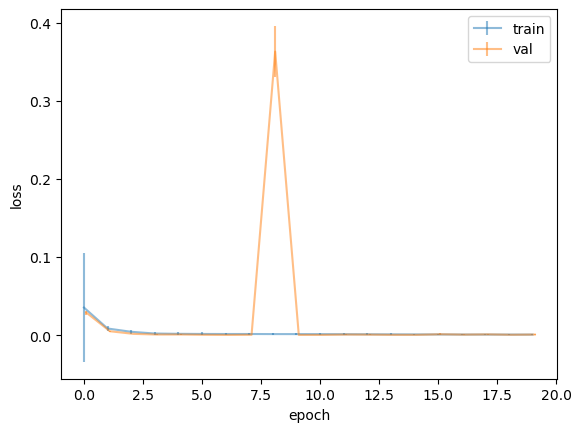

In [218]:
cnn.plot_epochs(odata['epochs'])

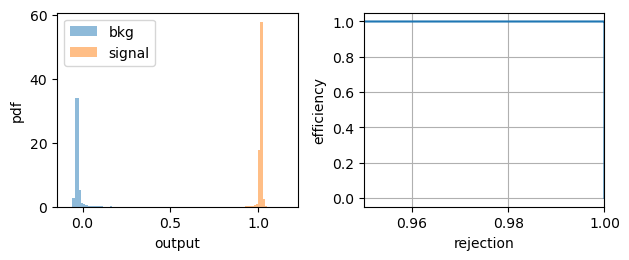

In [219]:
cnn.plot_roc(odata['y'], odata['yp'], 0.95)

In [220]:
def plot_event(idata, odata, labels, ievt = -1):
    i0   = odata['index'][0]
    size = odata['index'][1] - i0
    ievt = int(np.random.choice(size, 1)) if ievt == -1 else ievt
    kevt = i0 + ievt
    print('event ', kevt)
    y0   = idata.ys[kevt]
    yt0  = odata['y'][ievt]
    ytp  = odata['yp'][ievt]
    print('target test      ', int(y0), int(y0) == int(yt0))
    assert int(y0) == int(yt0)
    print('target test pred ', float(ytp))
    dp.plot_imgs(idata.xs, kevt, labels)
    for i, label in enumerate(labels):
        print('total       ', label, np.sum(idata.xs[kevt][i]))
    dp.plot_imgs(idata.zs, kevt, list(idata.zlabels))
    return

event  182392
target test       1 True
target test pred  1.0182983875274658
total        test 1.0


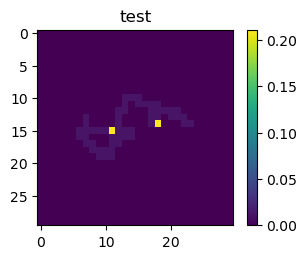

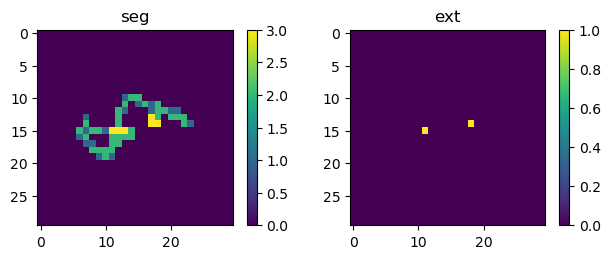

<Figure size 640x480 with 0 Axes>

In [247]:
plot_event(idata, odata, labels)

8
[0] 0.2
1.0


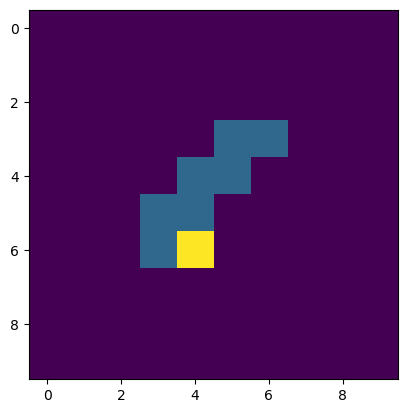

In [48]:
ievt   = 172262
segimg = idata.zdic['seg'][ievt]
extimg = idata.zdic['ext'][ievt]
yi     = idata.y[ievt]
plt.imshow(segimg)
ttimg  = cnn.ttimage(segimg, extimg, yi)
plt.imshow(ttimg)
print(np.sum(ttimg))

In [49]:
cnn.test_ttimage(segimg, extimg, yi, ttimg, 0.2)